# Ejercicio 2: Overfitting en Julia
Este notebook implementa el cálculo de R², R² ajustado y R² fuera de muestra usando modelos polinomiales en Julia.

In [ ]:
import Pkg; Pkg.add("StatsBase")

In [ ]:
#creamos la carpeta de output
output_path = "C:\\Users\\johnb\\Documents\\GitHub\\causalai-2025\\Julia\\output"
mkpath(output_path)

In [ ]:
using Random, LinearAlgebra, Statistics
using Plots
using StatsBase

Random.seed!(123)
n = 1000
X = rand(n)
X = sort(X)
ϵ = randn(n)
y = exp.(4 .* X) .+ ϵ

function r2(y, ŷ)
    ss_res = sum((y .- ŷ).^2)
    ss_tot = sum((y .- mean(y)).^2)
    return 1 - ss_res/ss_tot
end

function r2_adjusted(r2::Float64, n::Int, k::Int)
    if k >= n - 1
        return NaN
    else
        return 1 - (1 - r2) * (n - 1) / (n - k - 1)
    end
end

features_list = [1, 2, 5, 10, 20, 50, 100, 200, 500]

r2_full = Float64[]
r2_adj = Float64[]
r2_out = Float64[]

train_idx = sample(1:n, Int(round(0.75*n)), replace=false)
test_idx = setdiff(1:n, train_idx)

for p in features_list
    X_poly = hcat([X.^i for i in 1:p]...)
    β = X_poly \ y
    ŷ = X_poly * β
    
    r2_val = r2(y, ŷ)
    push!(r2_full, r2_val)
    push!(r2_adj, r2_adjusted(r2_val, n, p))

    X_train, y_train = X_poly[train_idx, :], y[train_idx]
    X_test, y_test = X_poly[test_idx, :], y[test_idx]

    β_train = X_train \ y_train
    ŷ_test = X_test * β_train
    push!(r2_out, r2(y_test, ŷ_test))
end

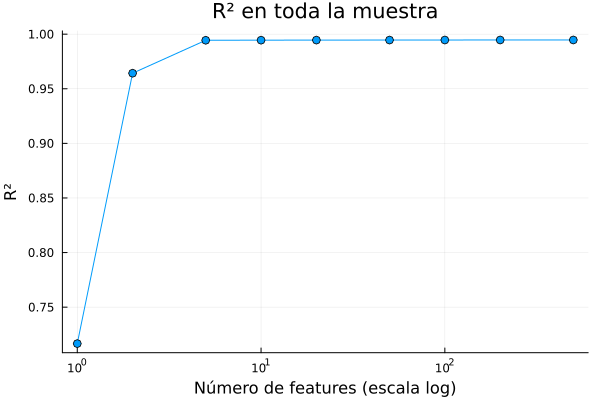

In [15]:
plot_r2_full = plot(features_list, r2_full, marker=:o, xscale=:log10,
    xlabel="Número de features (escala log)",
    ylabel="R²",
    title="R² en toda la muestra",
    legend=false)

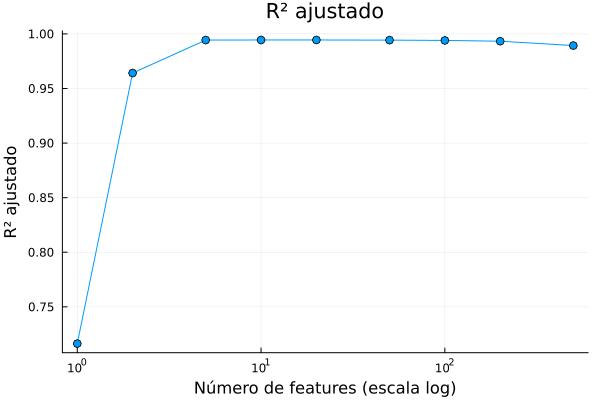

In [16]:
plot_r2_adj = plot(features_list, r2_adj, marker=:o, xscale=:log10,
    xlabel="Número de features (escala log)",
    ylabel="R² ajustado",
    title="R² ajustado",
    legend=false)

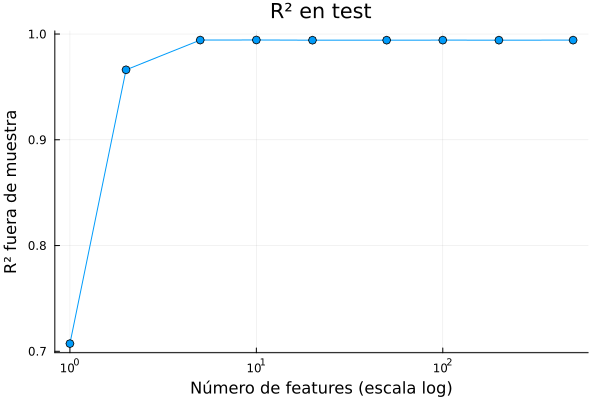

In [17]:
plot_r2_out =plot(features_list, r2_out, marker=:o, xscale=:log10,
    xlabel="Número de features (escala log)",
    ylabel="R² fuera de muestra",
    title="R² en test",
    legend=false)

In [18]:
#guardamos los graficos en la carpeta output
savefig(plot_r2_full, joinpath(output_path, "r2_full.png"))
savefig(plot_r2_adj, joinpath(output_path, "r2_adj.png"))
savefig(plot_r2_out, joinpath(output_path, "r2_out.png"))

"C:\\Users\\johnb\\Documents\\GitHub\\causalai-2025\\Julia\\output\\r2_out.png"

## Evaluación de resultados obtenidos

En los tres gráficos se observa un patrón consistente en cuanto al incremento en el número de variables explicativas eleva rápidamente la capacidad explicativa del modelo hasta valores cercanos a uno, tanto en el R² de la muestra, como en el R² ajustado y el R² fuera de muestra.

**R² en toda la muestra**:  
A medida que se incorporan más regresores (X, X², …, Xᵖ), el modelo logra capturar de manera más precisa la relación no lineal entre X y Y. Este resultado es esperado porque las variables añadidas son relevantes, pues no se trata de ruido, sino de transformaciones con potencias directamente vinculadas con el proceso generador de datos.

**R² ajustado**:  
Normalmente, el R² ajustado penaliza la inclusión de regresores irrelevantes. Sin embargo, en este ejercicio, como todos los regresores contienen información relacionada con Y, la penalización no reduce significativamente el estadístico, que también se mantiene cercano a 1. Esto refleja que la ganancia de ajuste supera con claridad el costo de complejidad.

**R² fuera de muestra**:  
El desempeño en el conjunto de prueba confirma que no hay sobreajuste en sentido estricto. El modelo generaliza muy bien porque los regresores no son espurios; son potencias de X que reproducen la forma funcional subyacente de Y. En un escenario alternativo, donde hubiese regresores aleatorios o no correlacionados con la variable dependiente, el R² externo a la muestra caería cuando aumenta el número de variables, lo cual reflejaría el clásico problema de overfitting.
